# Import Libraries


In [22]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
import tensorflow as tf
import matplotlib.pyplot as plt
import os

# Check for GPU 


In [23]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


# GPU Configuration
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
        print("GPU memory growth enabled")
    except RuntimeError as e:
        print(e)
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'  # Force CPU usage


GPU memory growth enabled


# Hyperparameter


In [24]:

split = 0.85
sequence_length = 10
epochs = 50
learning_rate = 0.001

# Loading stock price data

In [25]:
# stock_data = pd.read_csv("stock_price.csv")
stock_data = pd.read_csv("gold_price.csv")
column = ['Close']
columns_to_load = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']


# Data preparation

In [26]:
len_stock_data = stock_data.shape[0]
train_examples = int(len_stock_data * split)

train = stock_data.get(column).values[:train_examples]
test = stock_data.get(column).values[train_examples:]

len_train = train.shape[0]
len_test = test.shape[0]


# Initialize and fit scaler

In [27]:
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train.reshape(-1, 1))
test_scaled = scaler.transform(test.reshape(-1, 1))


# Prepare training data



In [28]:
X_train = []
y_train = []
for i in range(len_train - sequence_length):
    X_train.append(train_scaled[i:i + sequence_length].flatten())
    y_train.append(train_scaled[i + sequence_length])
X_train = np.array(X_train)
y_train = np.array(y_train)

# Prepare test data



In [29]:
X_test = []
y_test = []
for i in range(len_test - sequence_length):
    X_test.append(test_scaled[i:i + sequence_length].flatten())
    y_test.append(test_scaled[i + sequence_length])
X_test = np.array(X_test)
y_test = np.array(y_test)

# Store original y_test values for evaluation


In [30]:
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))


# Direction Accuracy Method


In [31]:
def calculate_direction_accuracy(actual_values, predicted_values):
    """
    Calculate accuracy of predicted price movement direction
    Returns: accuracy and arrays of actual and predicted directions
    """
    # Calculate actual price movements (1 for up, 0 for down)
    actual_direction = (actual_values[1:] > actual_values[:-1]).astype(int)

    # Calculate predicted price movements (1 for up, 0 for down)
    predicted_direction = (predicted_values[1:] > predicted_values[:-1]).astype(int)

    # Calculate accuracy
    direction_accuracy = np.mean(actual_direction == predicted_direction)

    return direction_accuracy, actual_direction, predicted_direction


# Model



In [32]:
def model_create(X_train1, y_train1):
    tf.random.set_seed(1234)

    model = tf.keras.models.Sequential(
        [
            tf.keras.Input(shape=(X_train.shape[1],)),
            tf.keras.layers.Dense(units=50, activation="relu"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units=30, activation="relu"),
            tf.keras.layers.Dropout(0.05),
            tf.keras.layers.Dense(units=20, activation="relu"),
            tf.keras.layers.Dropout(0.01),
            tf.keras.layers.Dense(units=1, activation="linear")
        ]
    )

    model.compile(
        loss=tf.keras.losses.MeanSquaredError(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
    )

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        restore_best_weights=True
    )

    model.fit(
        X_train1, y_train1,
        epochs=epochs,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )
    return model


# Evaluation 
## With the graphs 

In [33]:

def evaluate(predictions):
    mae = mean_absolute_error(y_test_original, predictions)
    mape = mean_absolute_percentage_error(y_test_original, predictions)

    # Calculate direction accuracy
    dir_acc, actual_dir, pred_dir = calculate_direction_accuracy(y_test_original, predictions)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # Plot 1: Price predictions
    ax1.plot(y_test_original, label="Actual Values", color="blue", marker='o')
    ax1.plot(predictions, label="Predicted Values", color="red",
            linestyle='dashed', marker='x')
    ax1.set_title("Comparison of Predicted vs Actual Values")
    ax1.set_xlabel("Sample Index")
    ax1.set_ylabel("Price")
    ax1.legend()
    ax1.grid(True)

    # Plot 2: Direction predictions
    ax2.plot(actual_dir, label="Actual Direction", color="blue", marker='o')
    ax2.plot(pred_dir, label="Predicted Direction", color="red",
            linestyle='dashed', marker='x')
    ax2.set_title("Comparison of Predicted vs Actual Price Direction (1=Up, 0=Down)")
    ax2.set_xlabel("Sample Index")
    ax2.set_ylabel("Direction")
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return mae, mape, (1 - mape), dir_acc

# Run Model 


In [34]:

def run_model(n):
    total_mae = total_mape = total_acc = total_dir_acc = 0
    results = np.zeros((len_test - sequence_length, 1))

    for iteration in range(n):
        # Create and train initial model
        model = model_create(X_train, y_train)

        for j in range(len_test - sequence_length):
            current_input = X_test[j].reshape(1, sequence_length)
            prediction = model.predict(current_input, verbose=0)
            results[j] = scaler.inverse_transform(prediction.reshape(-1, 1))

            if j < len_test - sequence_length - 1:
                actual = y_test[j].reshape(1, 1)
                model.fit(current_input,
                         actual,
                         epochs=10,
                         verbose=0)

        mae, mape, acc, dir_acc = evaluate(results)
        total_mae += mae
        total_mape += mape
        total_acc += acc
        total_dir_acc += dir_acc

        print(f"Iteration {iteration + 1}:")
        print(f"MAE: {mae}")
        print(f"MAPE: {mape}")
        print(f"Price Accuracy: {acc}")
        print(f"Direction Accuracy: {dir_acc}\n")

    return (total_mae/n), (total_mape/n), (total_acc/n), (total_dir_acc/n), results.tolist()


# Main


Starting model training and evaluation...


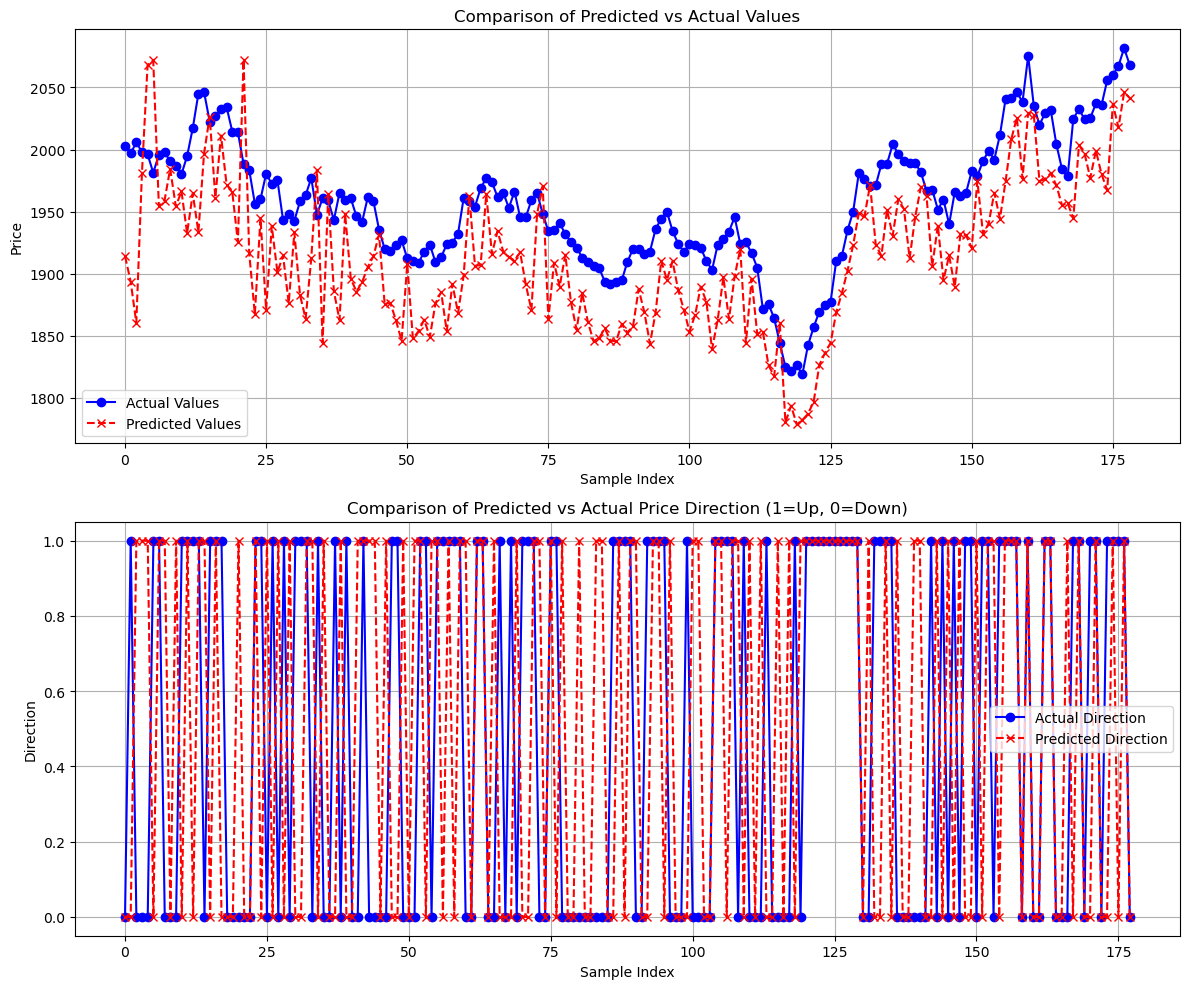

Iteration 1:
MAE: 47.383147340913006
MAPE: 0.02418259752820008
Price Accuracy: 0.9758174024717999
Direction Accuracy: 0.46629213483146065


Final Results:
Mean Absolute Error = 47.383147340913006
Mean Absolute Percentage Error = 0.02418259752820008
Price Accuracy = 0.9758174024717999
Direction Accuracy = 0.46629213483146065


In [35]:
print("Starting model training and evaluation...")
mae, mape, acc, dir_acc, preds = run_model(1)

print("\nFinal Results:")
print(f"Mean Absolute Error = {mae}")
print(f"Mean Absolute Percentage Error = {mape}")
print(f"Price Accuracy = {acc}")
print(f"Direction Accuracy = {dir_acc}")